In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [4]:
# Our main plotting package (must have explicit import of submodules)
import bokeh.io
import bokeh.plotting
import bokeh.layouts

import bokeh.layouts
import bokeh.models

import iqplot


# Enable viewing Bokeh plots in the notebook
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
# az.style.use("arviz-grayscale")
# from cycler import cycler
# default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
# plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)

In [3]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = pz.Binomial(n=1, p=theta_real).rvs(trials)
data

array([1, 0, 0, 0])

In [4]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000, random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


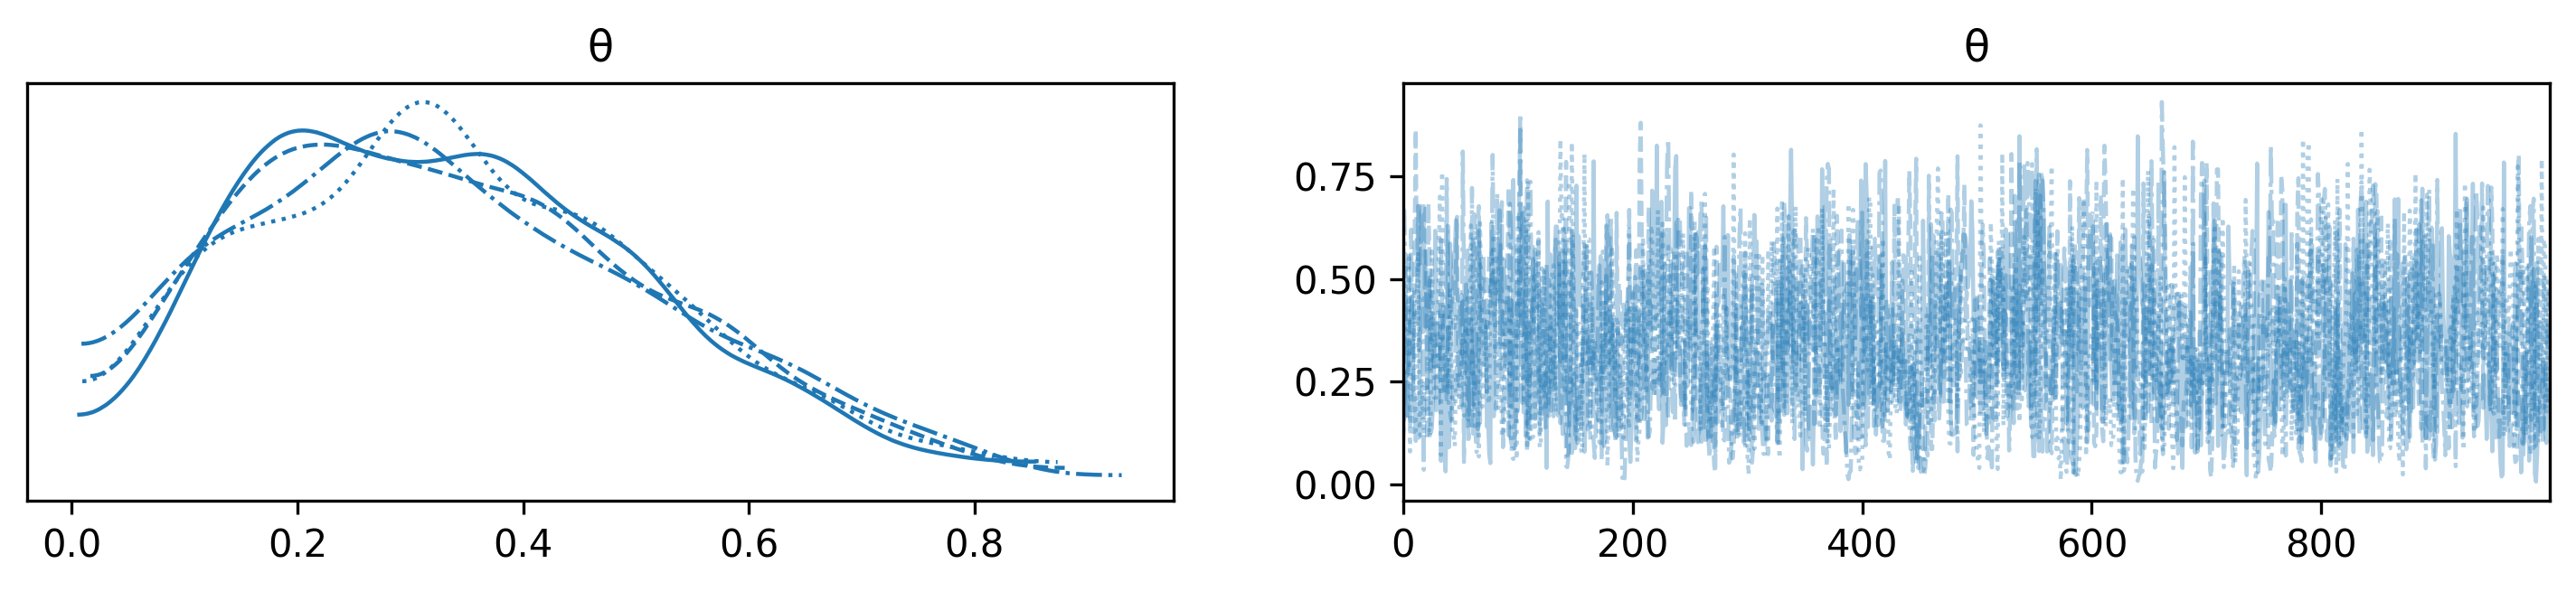

In [18]:
az.plot_trace(idata,backend='matplotlib')
plt.savefig("../fig/idata_trace.png")

In [17]:
# az.plot_trace(idata,backend_kwargs={'width':400, 'height':200},backend='bokeh')

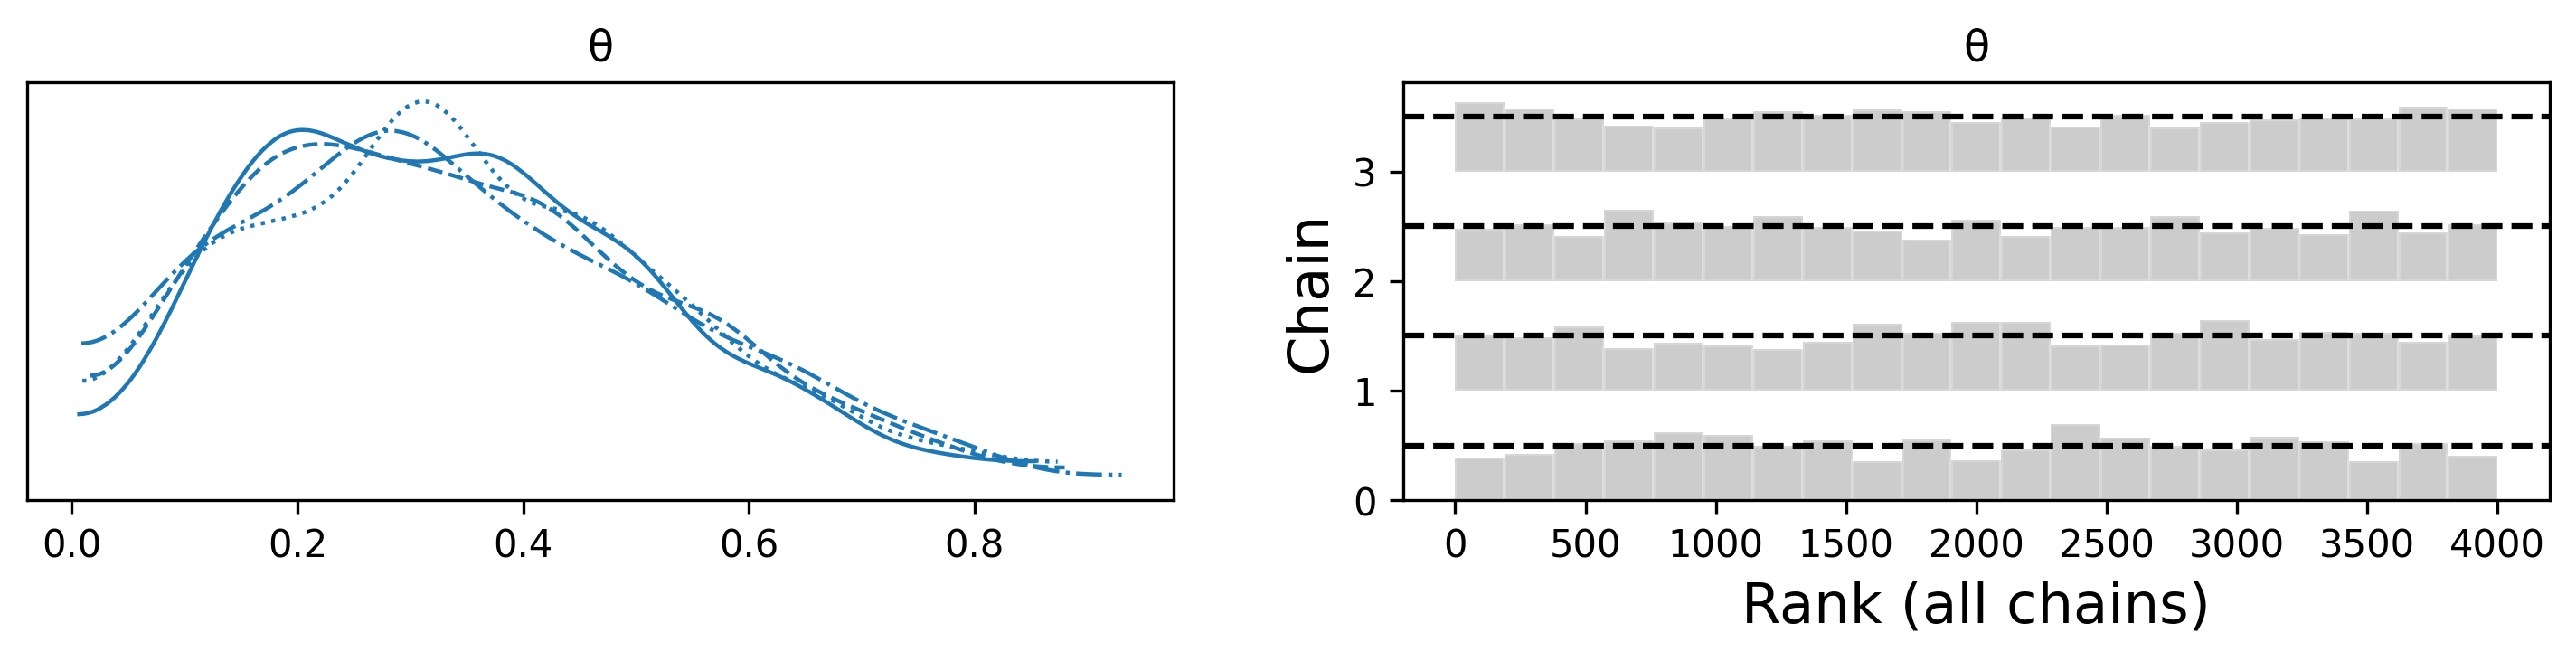

In [21]:
az.plot_trace(idata, kind="rank_bars", combined=False, rank_kwargs={"colors": "k"});
plt.savefig("../fig/idata_rank.png")

In [20]:
az.summary(idata, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
θ,0.34,0.18,0.04,0.67


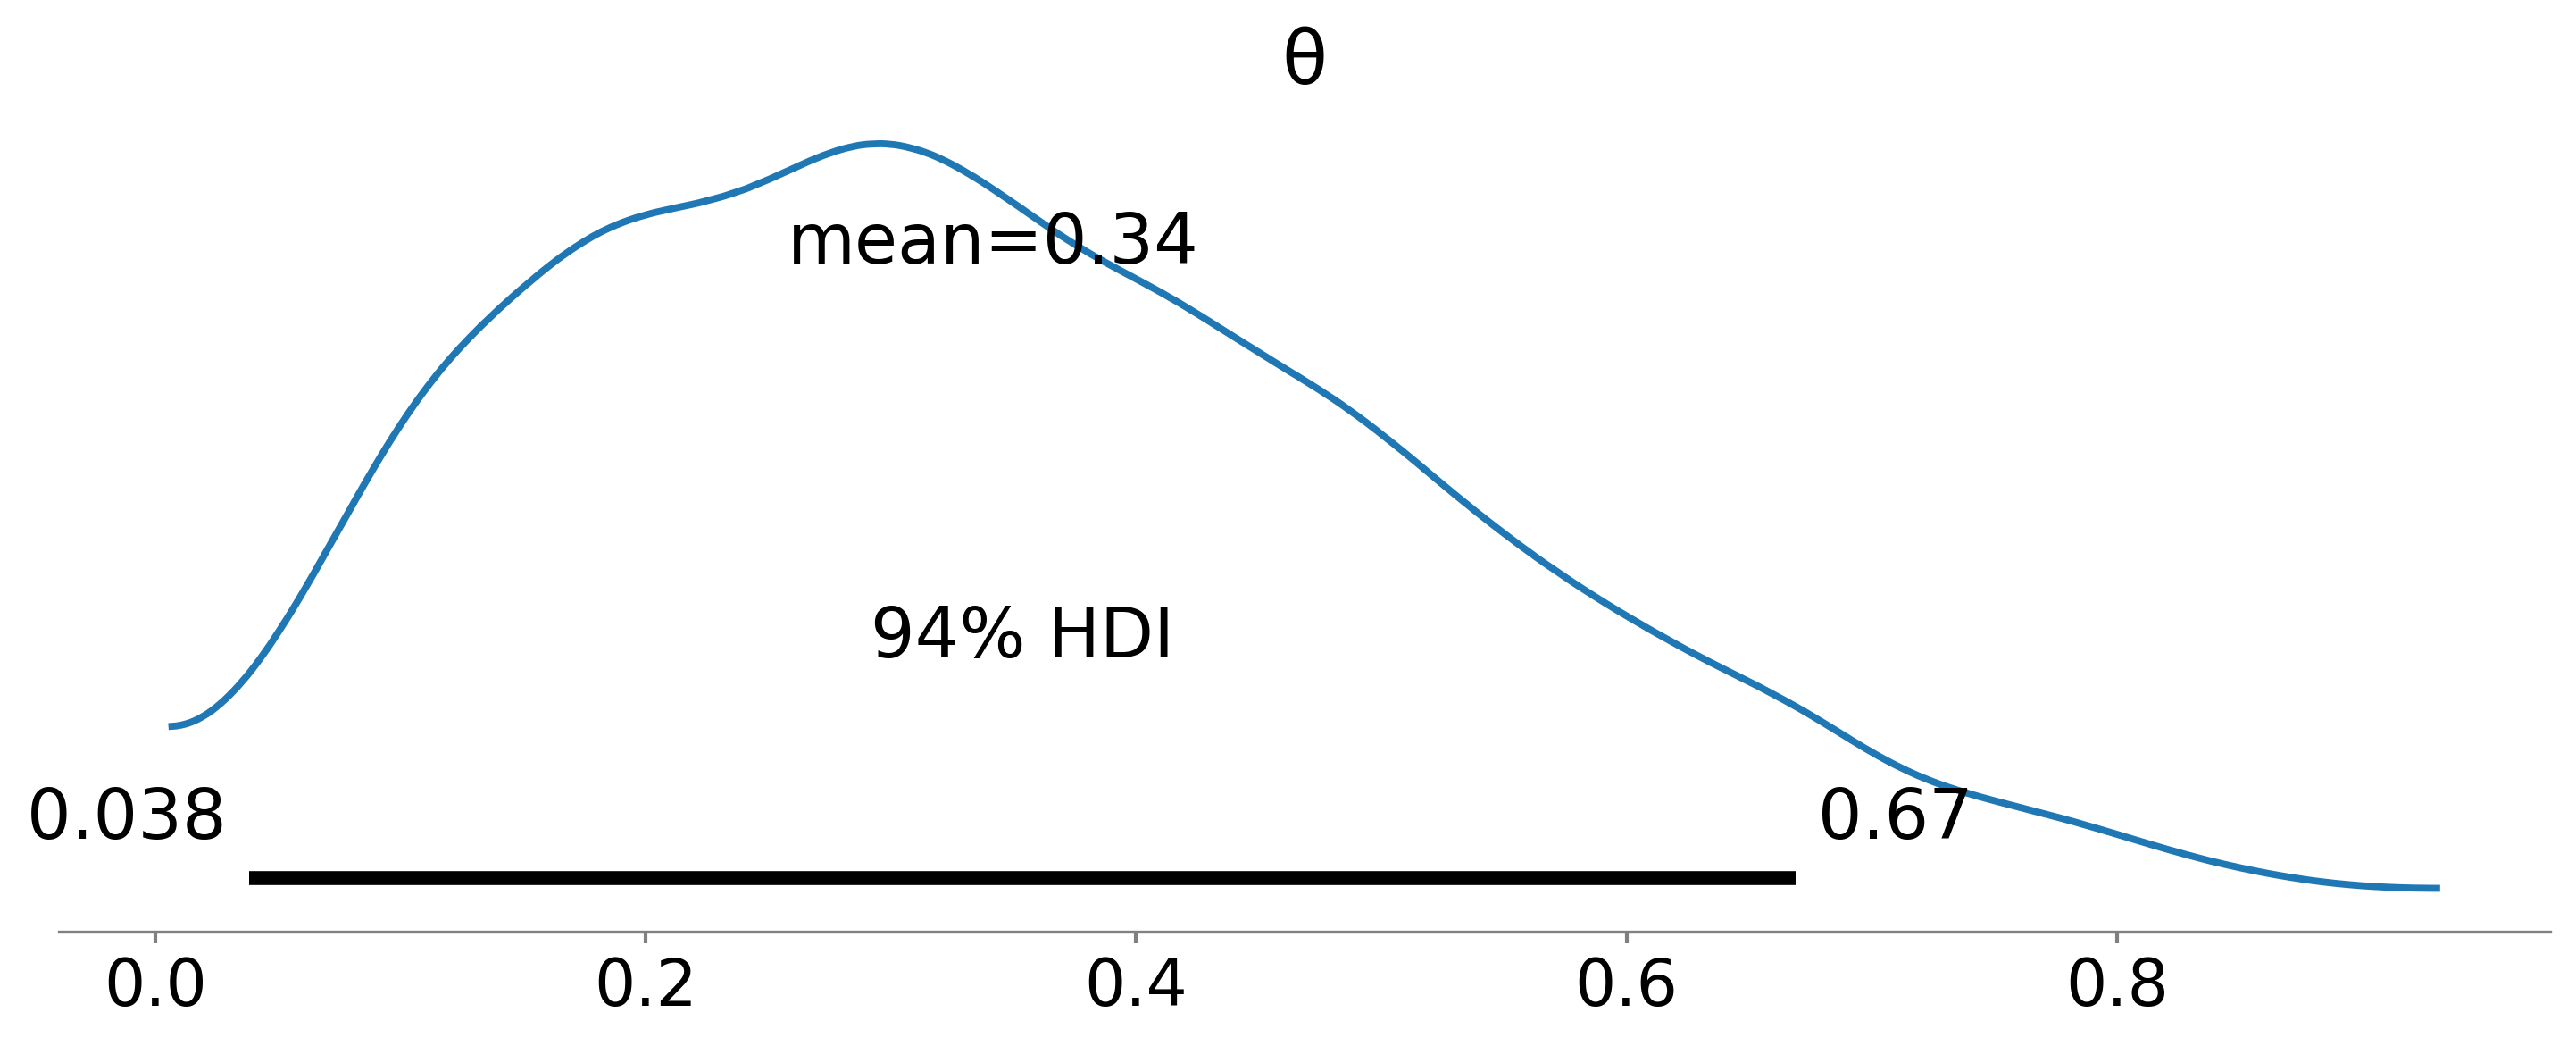

In [22]:
az.plot_posterior(idata, figsize=(12, 4))
plt.savefig("../fig/idata_posterior.png")

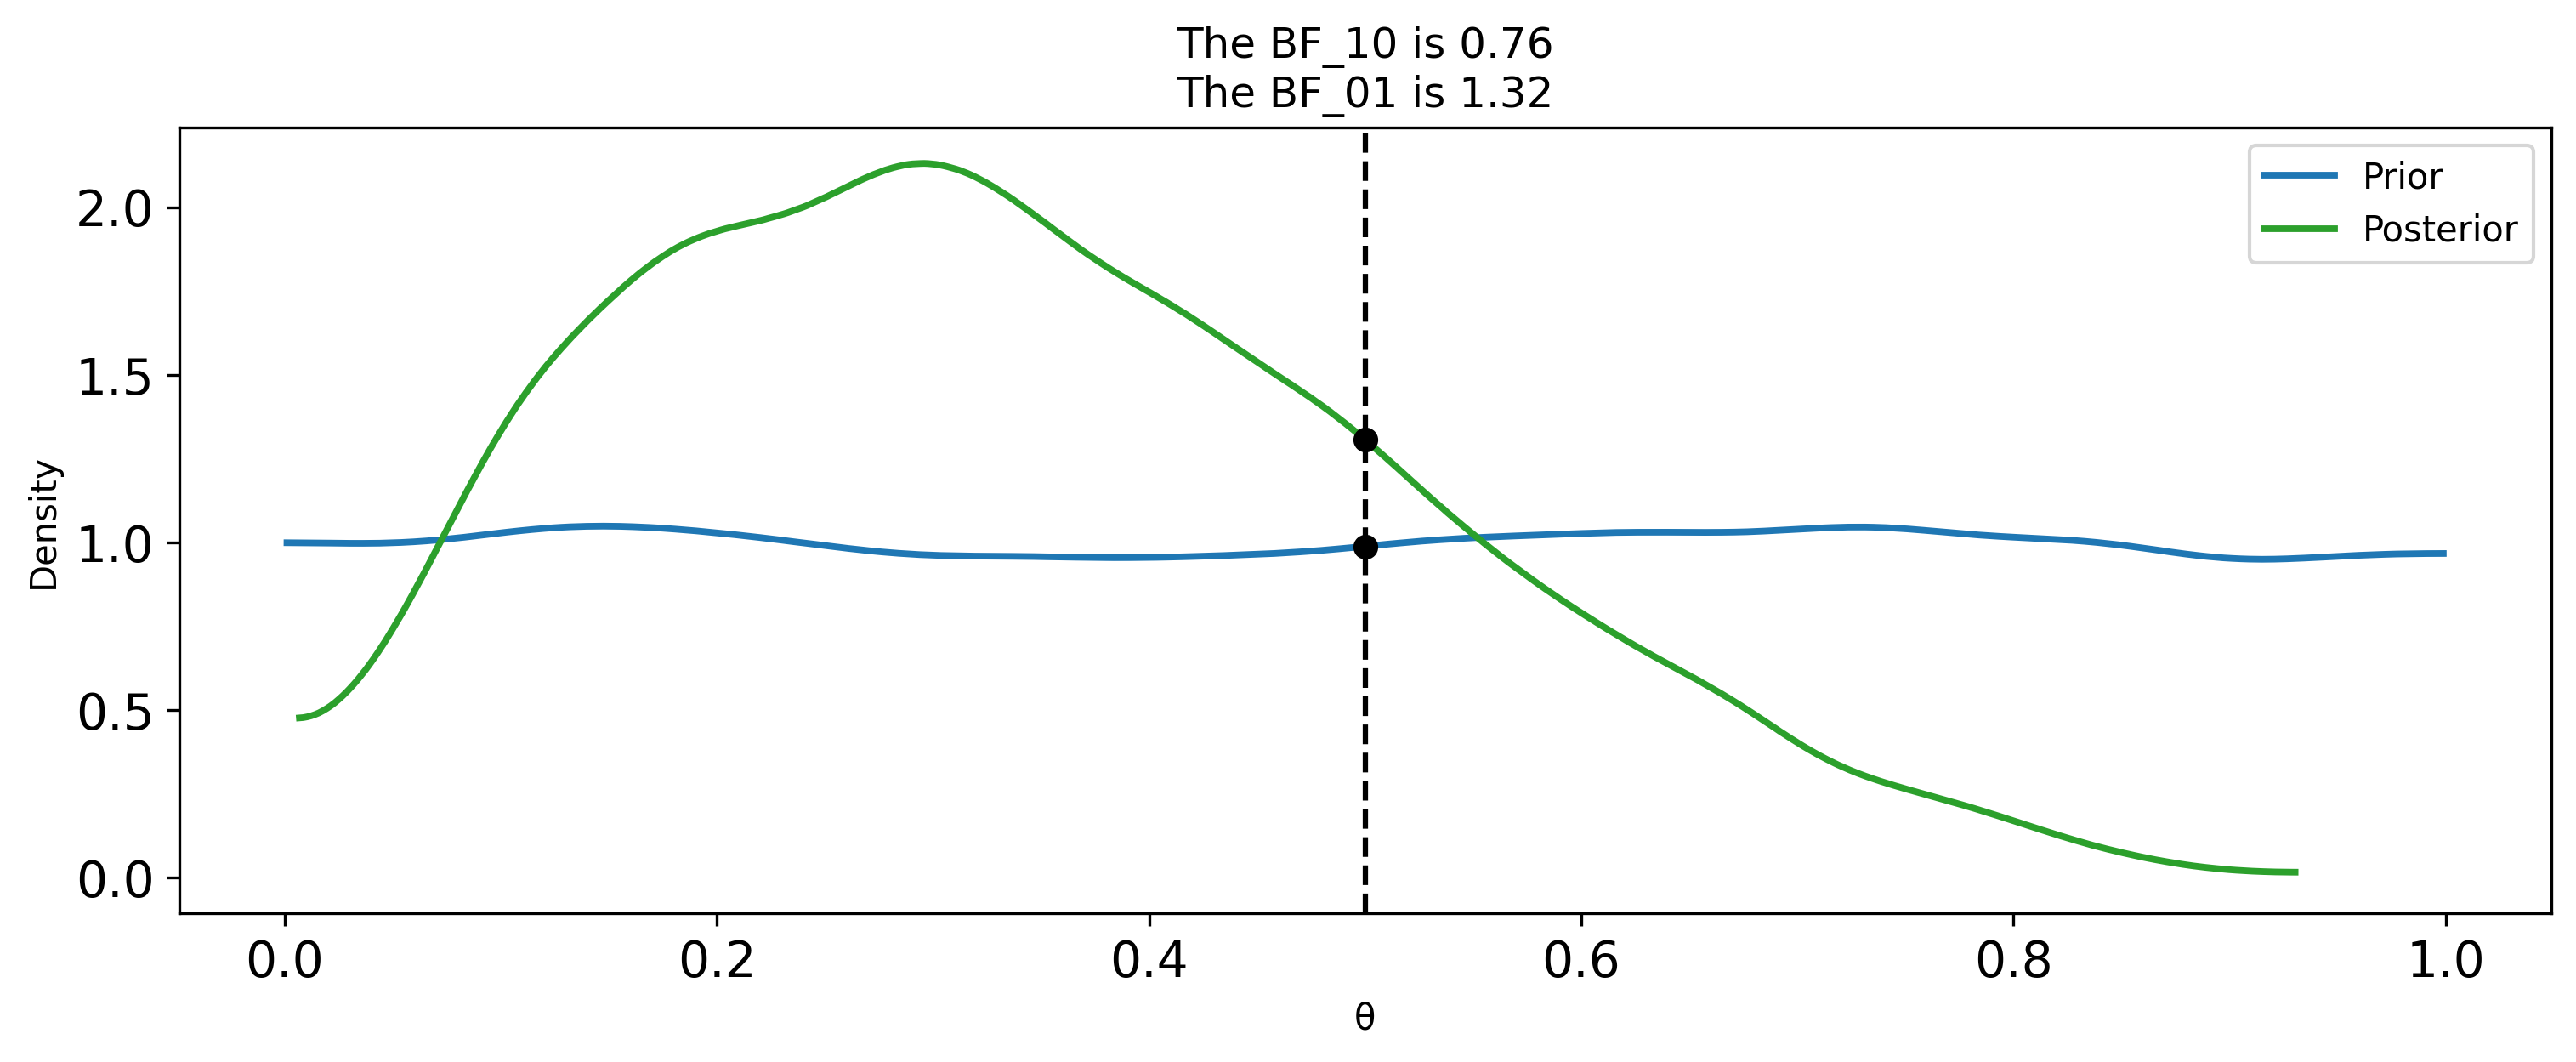

In [23]:
az.plot_bf(idata, var_name="θ", prior=np.random.uniform(0, 1, 10000), ref_val=0.5, figsize=(12, 4), colors=["C0", "C2"])
plt.savefig("../fig/idata_bf.png")

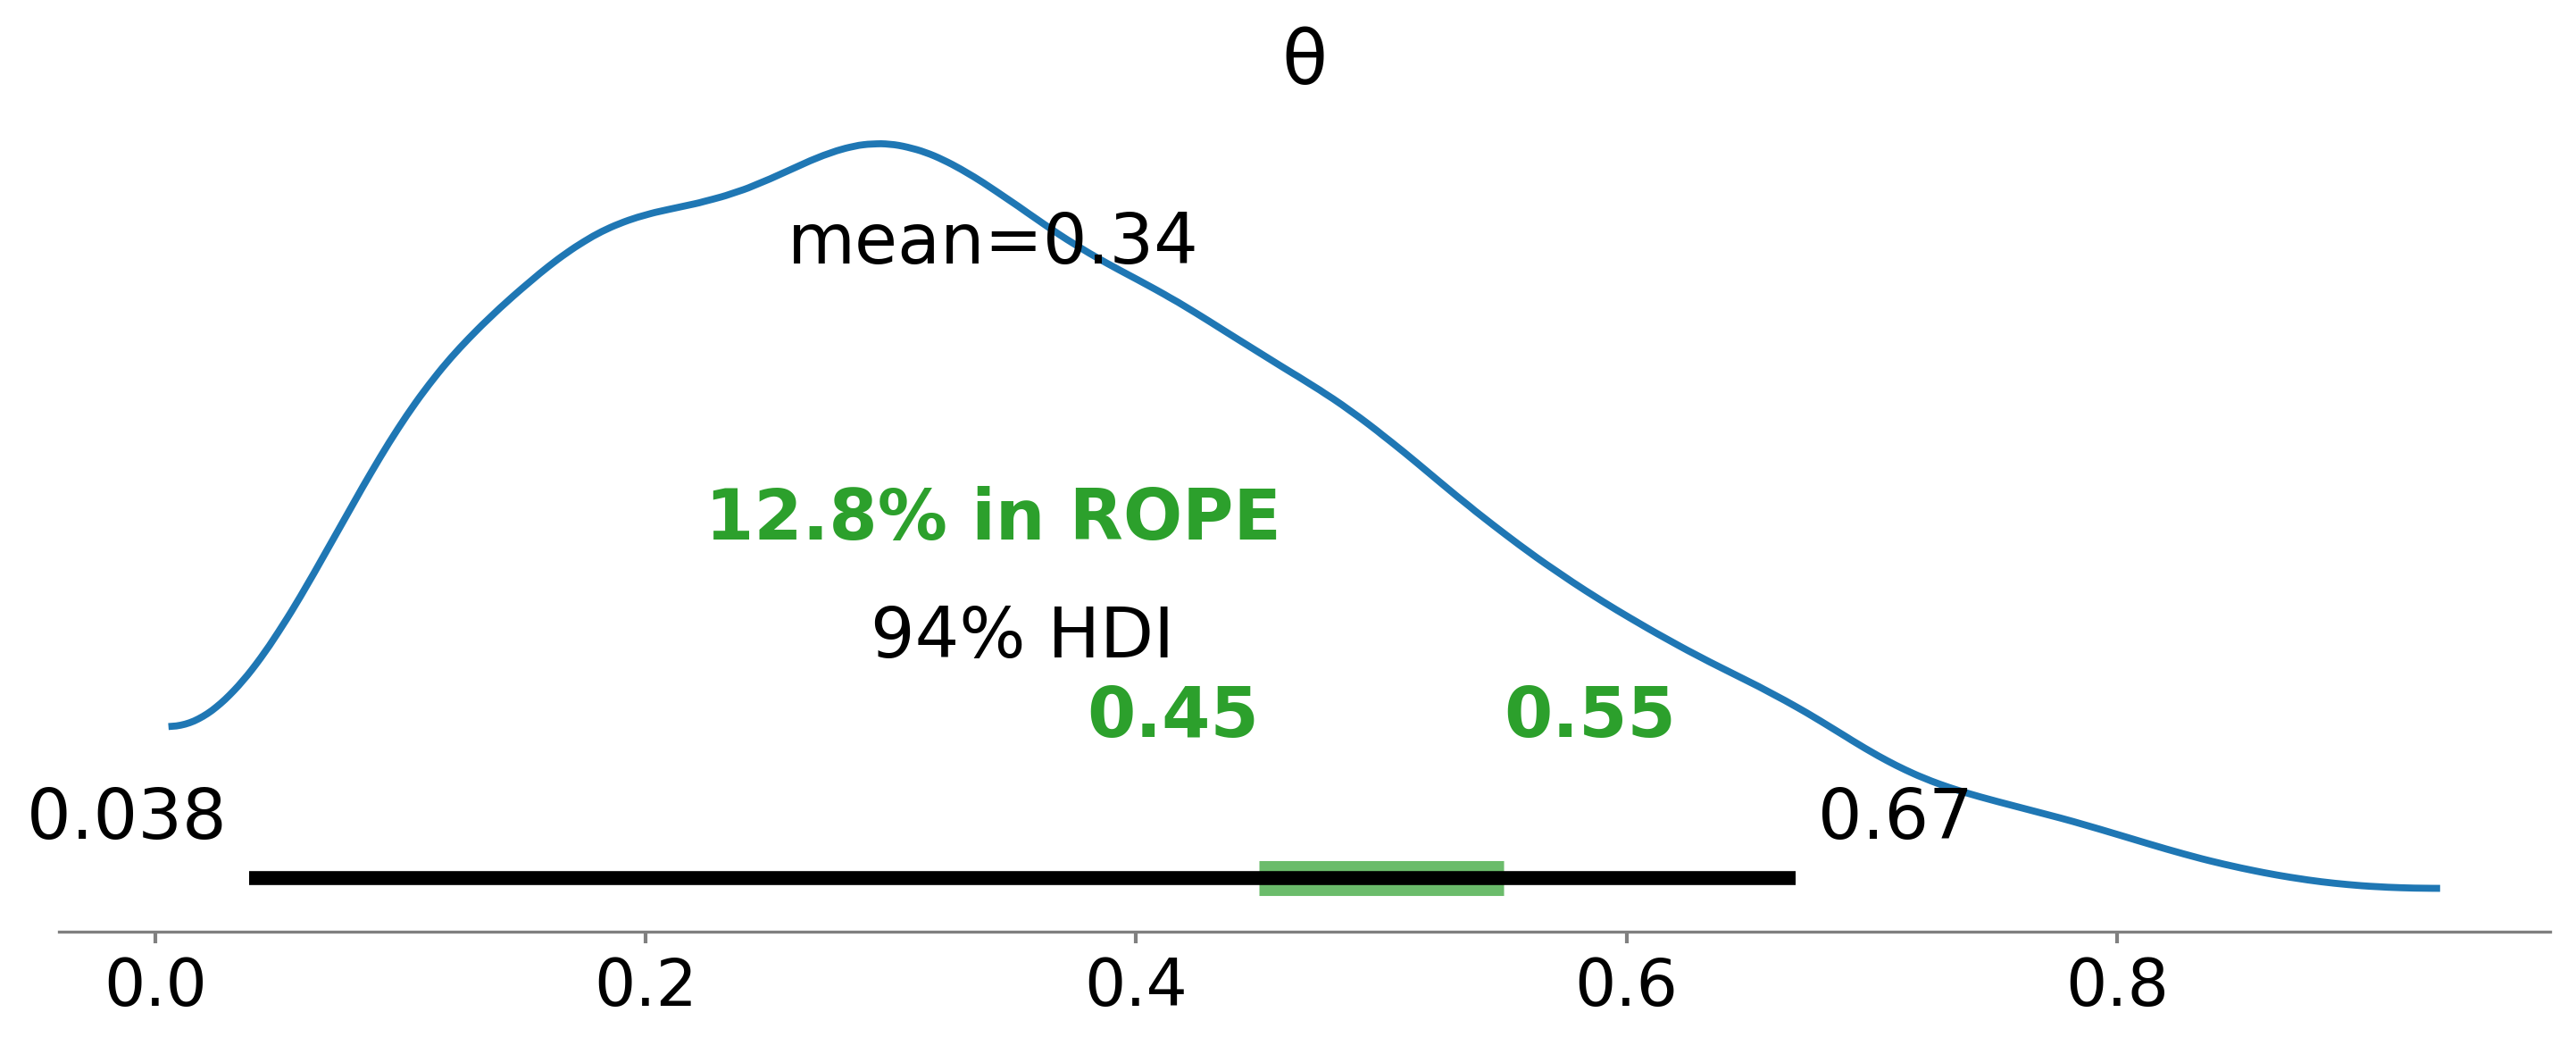

In [24]:
az.plot_posterior(idata, rope=[0.45, .55], figsize=(12, 4))
plt.savefig("../fig/idata_posterior_rope.png")


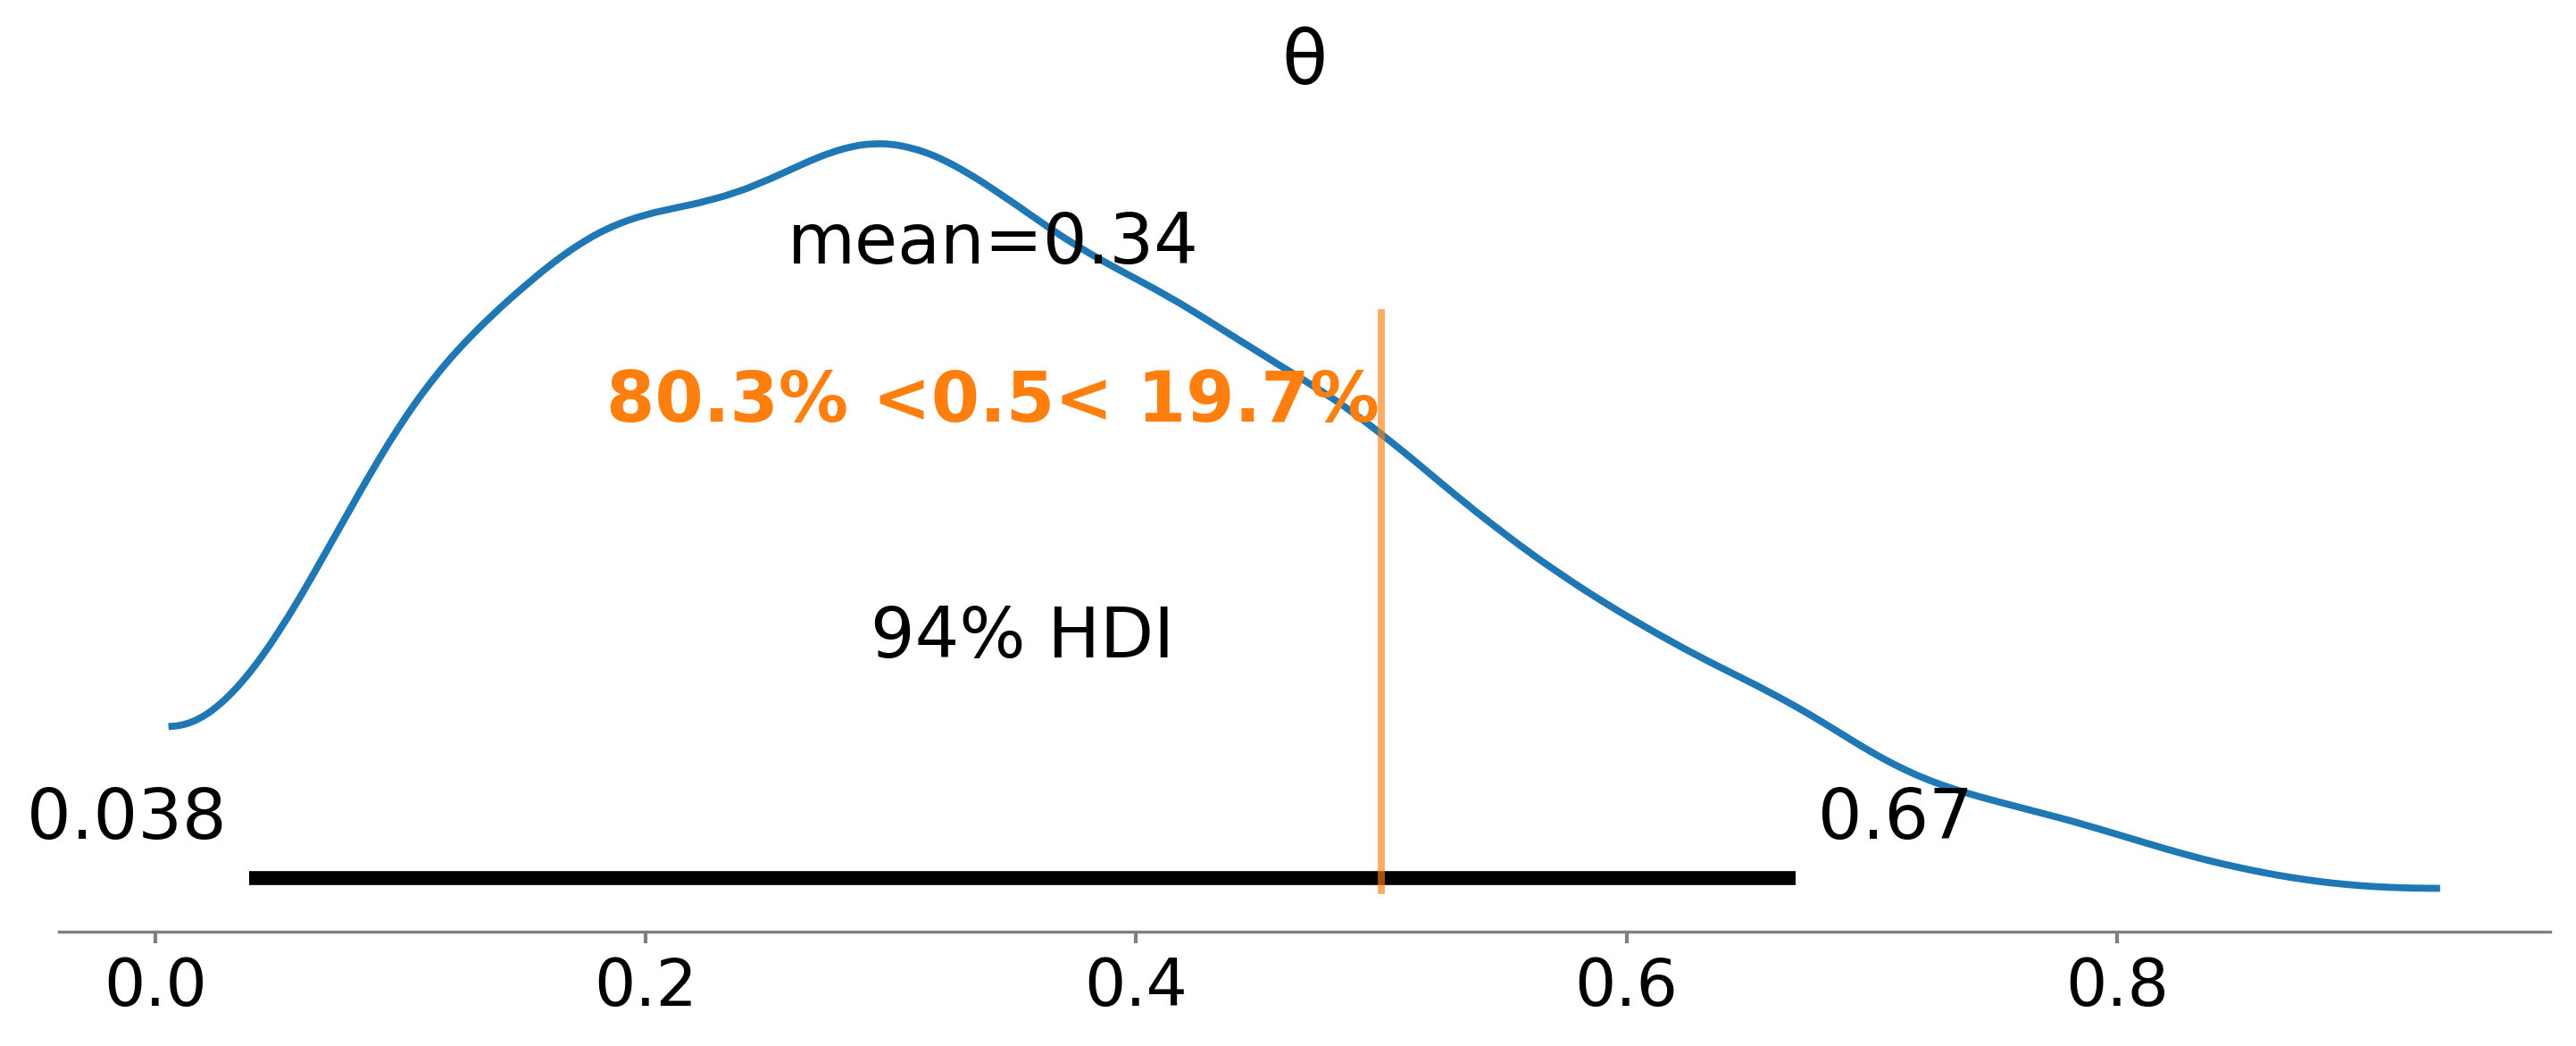

In [58]:
az.plot_posterior(idata, ref_val=0.5, figsize=(12, 4),backend='matplotlib')
plt.savefig("../fig/idata_posterior_ref.png")

In [59]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
np.argmin(lossf_a)

64

In [89]:
from bokeh.palettes import Category10 as palette
colors = palette[3]

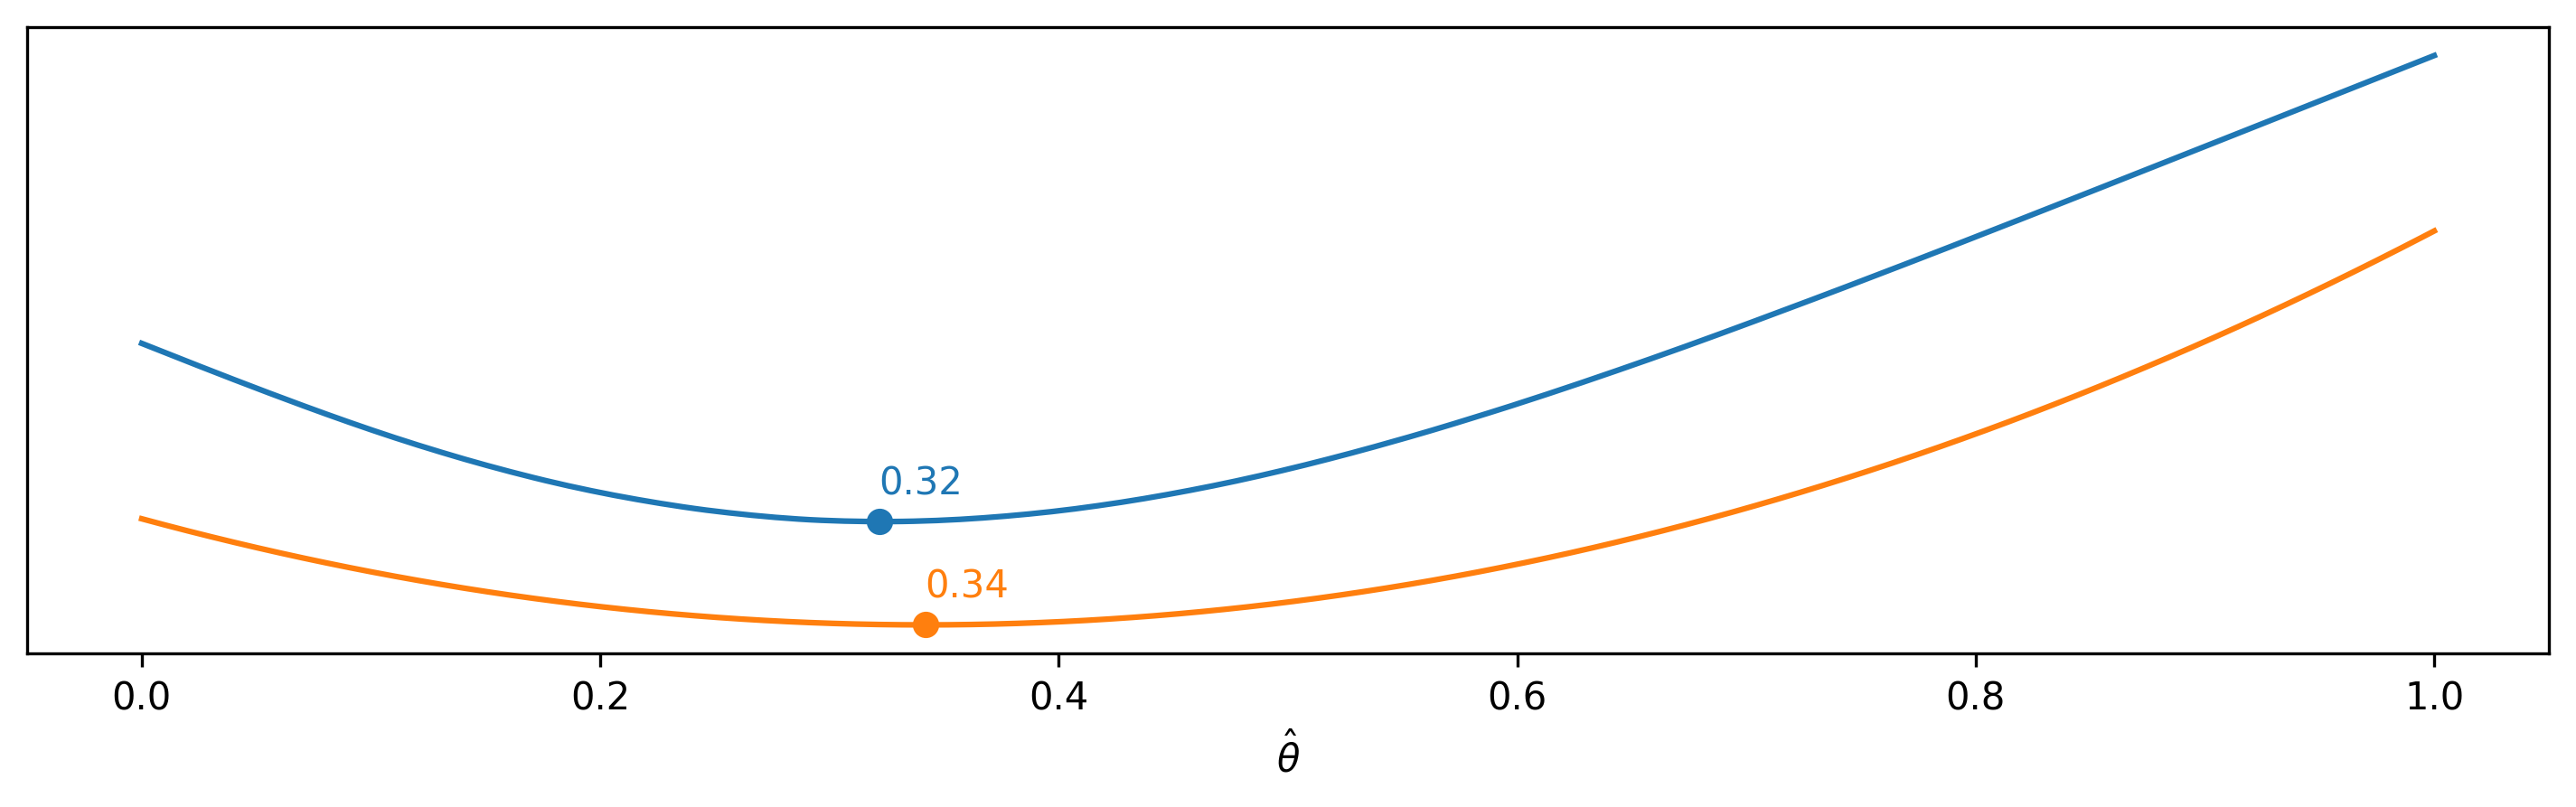

In [94]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
_, ax = plt.subplots(figsize=(12, 3))
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    ax.plot(grid, lossf, c)
    ax.plot(grid[mini], lossf[mini], 'o', color=c)
    ax.annotate('{:.2f}'.format(grid[mini]),
    (grid[mini], lossf[mini] + 0.03), color=c)

    ax.set_yticks([])
    ax.set_xlabel(r'$\hat \theta$')

plt.savefig("../fig/idata_loss.png")


In [101]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

# Create a Bokeh figure
p = bokeh.plotting.figure(width=800, height=250, x_axis_label='θ')

# Find minima and plot them
for idx, (lossf,lable) in enumerate(zip([lossf_a, lossf_b],['Loss A','Loss B'])):
    # Plot loss functions
    p.line(grid, lossf, line_color=colors[idx],line_width=2,legend_label=lable)

    mini = np.argmin(lossf)

    p.scatter([grid[mini]], [lossf[mini].item()], size=10, color=colors[idx], marker='circle')
    # Add text annotation
    annotation = bokeh.models.Label(x=grid[mini], y=(lossf[mini] + 0.03).item(),
                                    text='{:.2f}'.format(grid[mini]),
                                    text_color=colors[idx])
    p.add_layout(annotation)


p.xgrid.visible = False
p.yaxis.ticker = []


p.legend.location = "bottom_right"
# Save or show the plot
# output_file("../fig/idata_loss_bokeh.html")
bokeh.plotting.show(p)

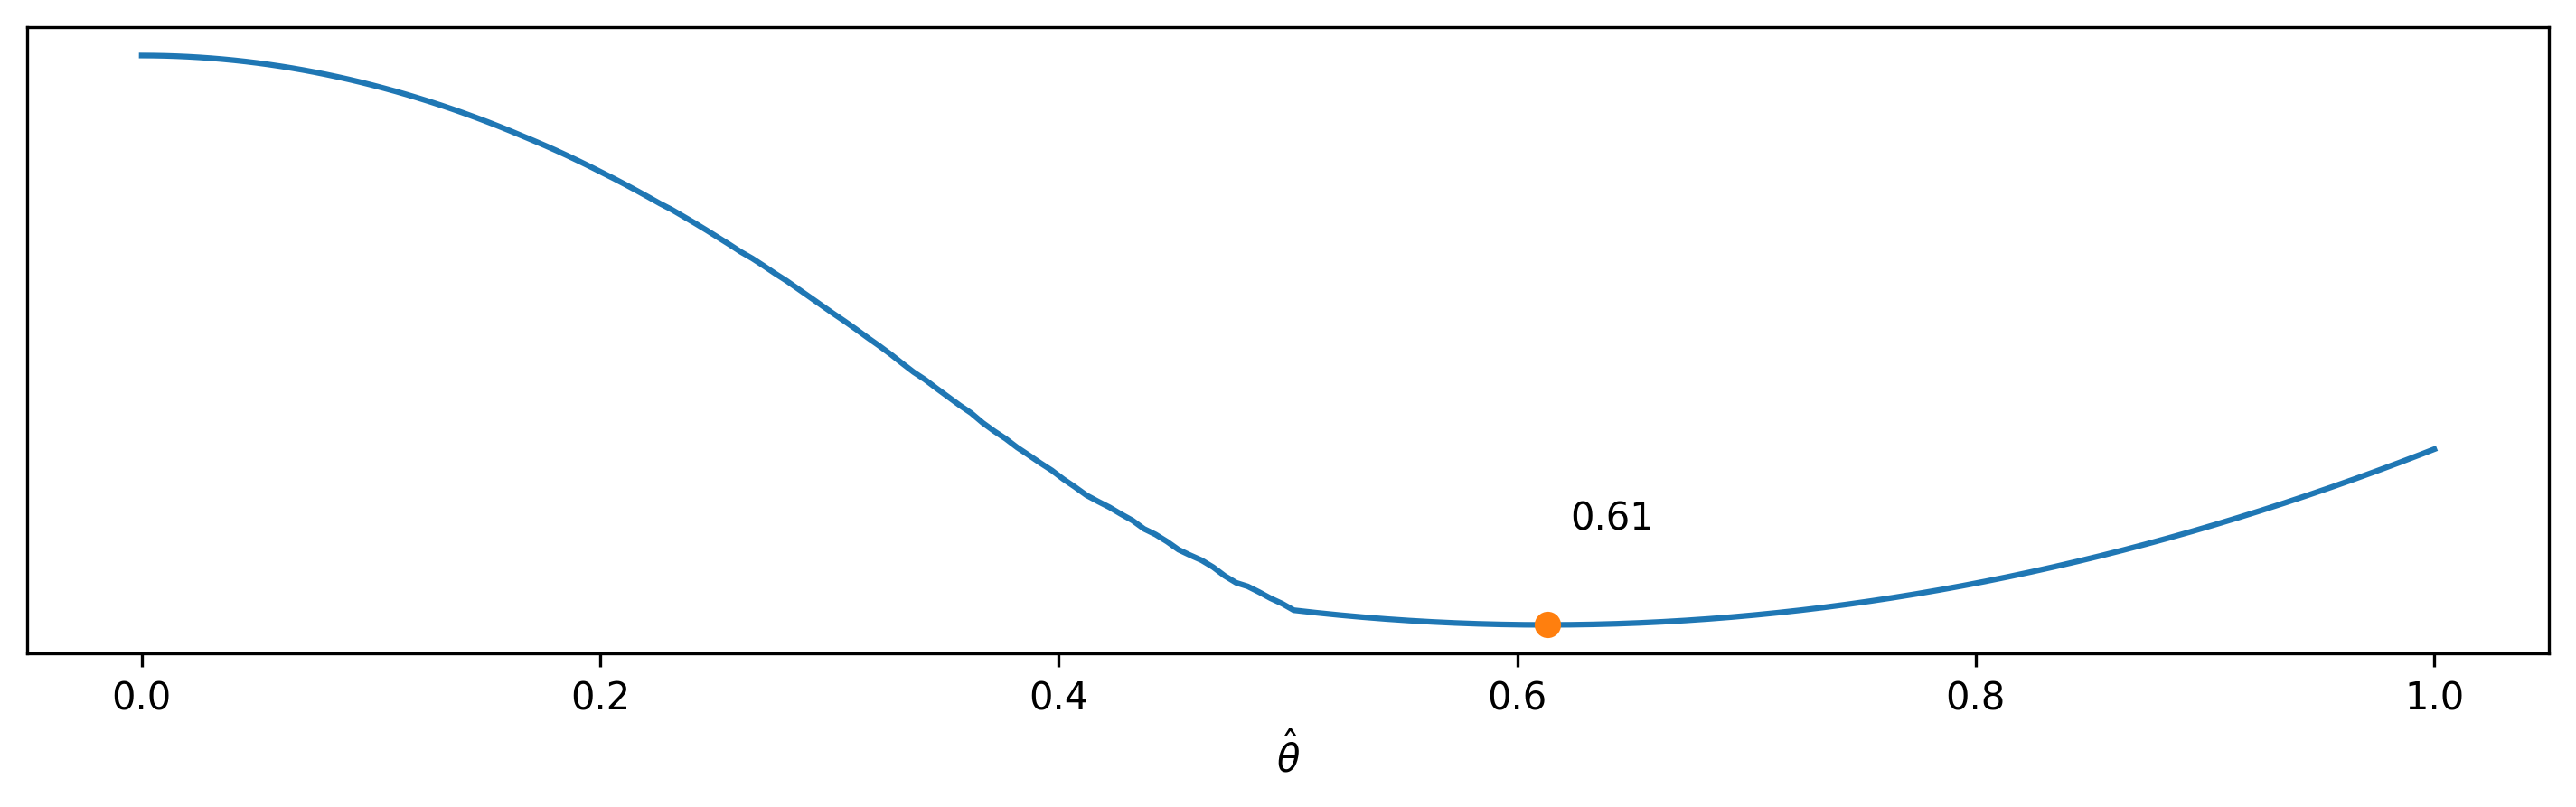

In [102]:
lossf = []
for i in grid:
    if i < 0.5:
        f = 1/np.median(θ_pos / np.abs(i**2 - θ_pos))
    else:
        f = np.mean((i - θ_pos)**2 + np.exp(-i)) - 0.25
    lossf.append(f)
mini = np.argmin(lossf)
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(grid, lossf)
ax.plot(grid[mini], lossf[mini], 'o')
ax.annotate('{:.2f}'.format(grid[mini]),
(grid[mini] + 0.01, lossf[mini] + 0.1))
ax.set_yticks([])
ax.set_xlabel(r'$\hat \theta$')
plt.savefig("../fig/idata_loss2.png")

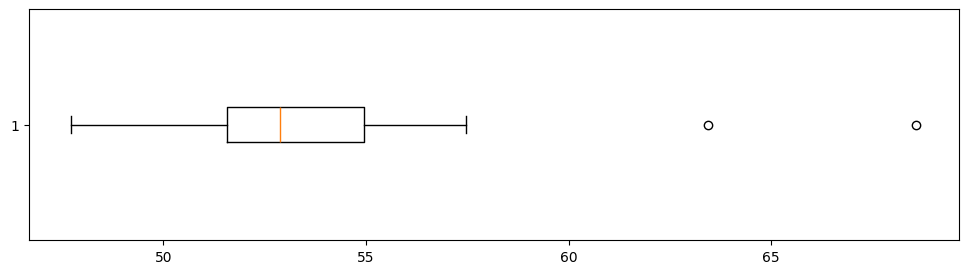

In [7]:
data = np.loadtxt("data/chemical_shifts.csv")
_, ax = plt.subplots(figsize=(12, 3))
ax.boxplot(data, vert=False)
plt.savefig("../fig/boxplot.png")

In [8]:
data

array([51.06, 55.12, 53.73, 50.24, 52.05, 56.4 , 48.45, 52.34, 55.65,
       51.49, 51.86, 63.43, 53.  , 56.09, 51.93, 52.31, 52.33, 57.48,
       57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
       51.94, 54.95, 50.39, 52.91, 51.5 , 52.68, 47.72, 49.73, 51.82,
       54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42,
       54.3 , 53.84, 53.16])

In [25]:
p = iqplot.box(
    data=data,
    x_axis_label='',
    outlier_marker="diamond",
    box_kwargs=dict(fill_color="#7C0000"),
    outlier_kwargs=dict(size=10),
    whisker_kwargs=dict(line_color="#7C0000", line_width=2),
    width=1000,
    height=250
)

bokeh.io.show(p)

In [36]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sigma=5)
    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data)
    idata_g = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


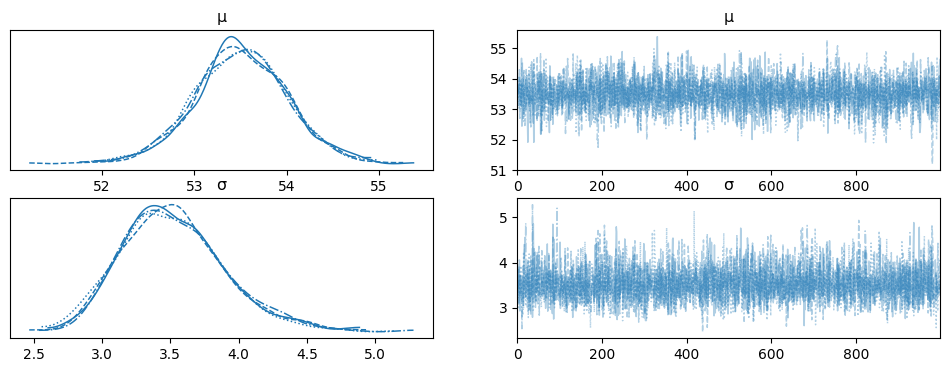

In [27]:
az.plot_trace(idata_g);
plt.savefig("../fig/idata_g_trace.png")

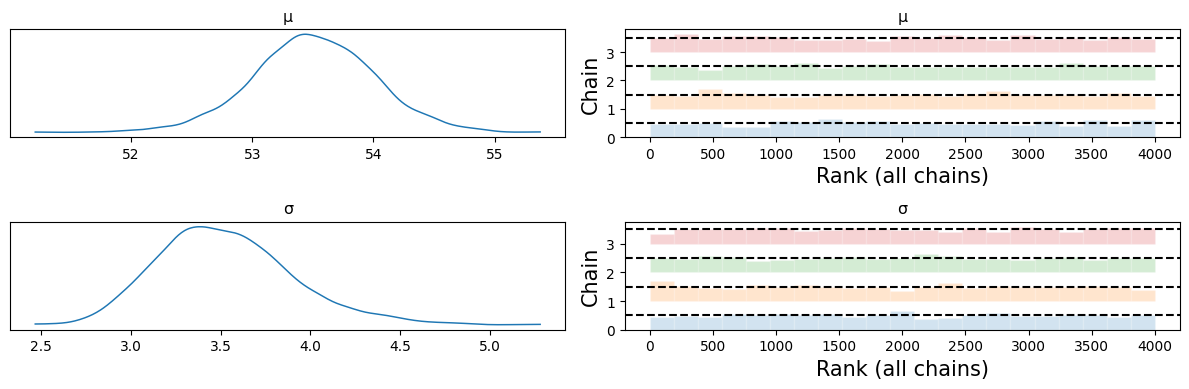

In [70]:
az.plot_trace(idata_g, var_names=["μ", "σ"], combined=True,kind="rank_bars");
plt.tight_layout()

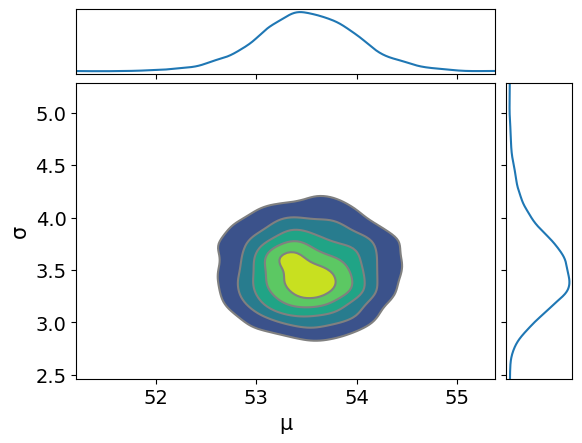

In [72]:
az.plot_pair(idata_g, kind='kde', marginals=True)
# plt.tight_layout()
plt.savefig("../fig/idata_g_pair.png")

In [56]:
idata_g

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [52]:
idata_g.posterior['μ'].values

array([[54.01464173, 53.79250745, 53.79250745, ..., 54.41849031,
        54.41849031, 54.62838694],
       [53.19024135, 53.48144427, 53.68261671, ..., 53.24626618,
        52.98239472, 52.98239472],
       [53.85437223, 53.11601402, 53.26282154, ..., 53.38929971,
        53.68396014, 53.80856311],
       [53.81279917, 53.49361867, 53.39476665, ..., 53.08444666,
        54.15015846, 53.22932863]])

In [46]:
idata_g.observed_data.Y.values

array([51.06, 55.12, 53.73, 50.24, 52.05, 56.4 , 48.45, 52.34, 55.65,
       51.49, 51.86, 63.43, 53.  , 56.09, 51.93, 52.31, 52.33, 57.48,
       57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
       51.94, 54.95, 50.39, 52.91, 51.5 , 52.68, 47.72, 49.73, 51.82,
       54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42,
       54.3 , 53.84, 53.16])

In [33]:
az.summary(idata_g, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
μ,53.50,0.50,52.52,54.43
σ,3.52,0.38,2.86,4.25


In [58]:
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True, random_seed=4591)


Sampling: [Y]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

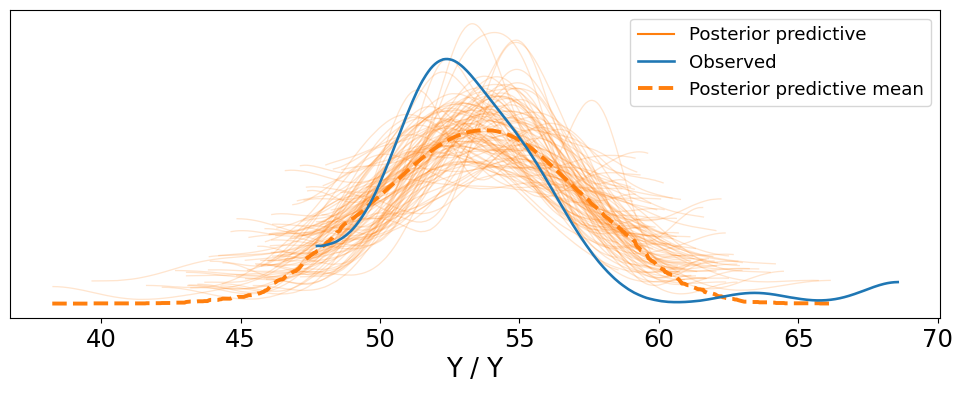

In [59]:
az.plot_ppc(idata_g, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plt.savefig("../fig/idata_g_ppc.png")

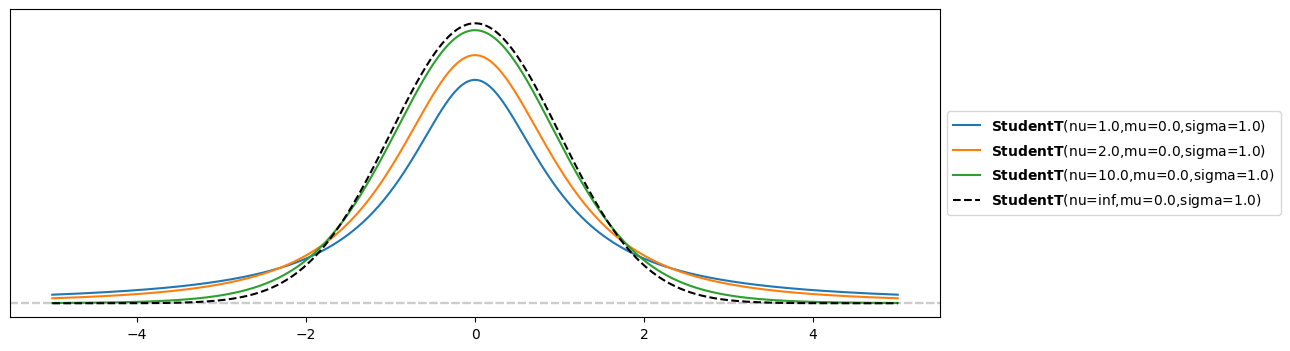

In [66]:
for nu in [1, 2, 10]:
    pz.StudentT(nu, 0, 1).plot_pdf(support=(-5, 5), figsize=(12, 4))

ax = pz.StudentT(np.inf, 0, 1).plot_pdf(support=(-5, 5), figsize=(12, 4), color="k")
ax.get_lines()[-1].set_linestyle("--")
pz.internal.plot_helper.side_legend(ax)
plt.savefig("../fig/student_t.png")

In [80]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sigma=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', nu=ν, mu=μ, sigma=σ, observed=data)
    idata_t = pm.sample(random_seed=4591)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


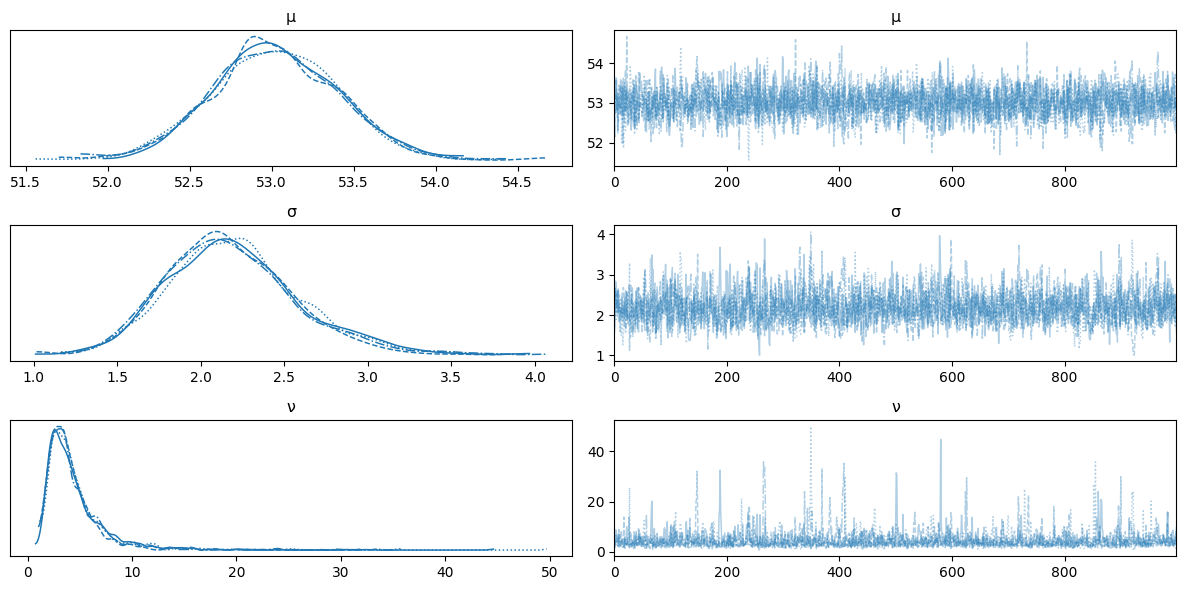

In [69]:
az.plot_trace(idata_t)
plt.tight_layout()
plt.savefig("../fig/idata_t_trace.png")

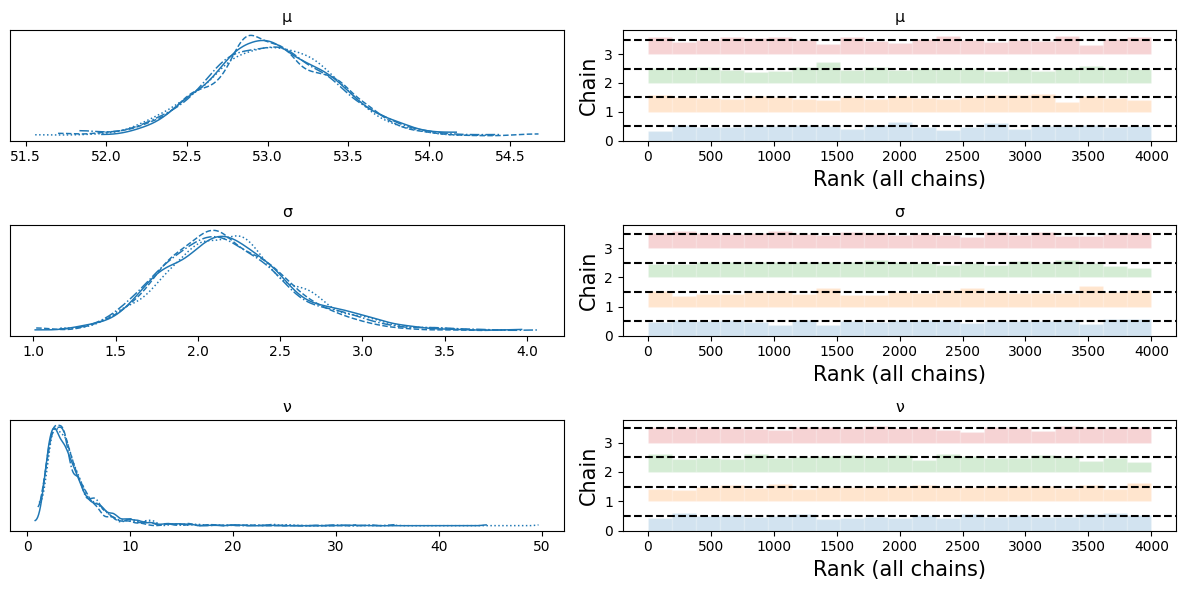

In [74]:
az.plot_trace(idata_t, var_names=["μ", "σ","ν"], combined=False, kind="rank_bars");
plt.tight_layout()

In [81]:
az.summary(idata_t, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
μ,53.02,0.38,52.29,53.72
σ,2.19,0.39,1.50,2.97
ν,4.53,3.44,1.14,9.43


Sampling: [y]


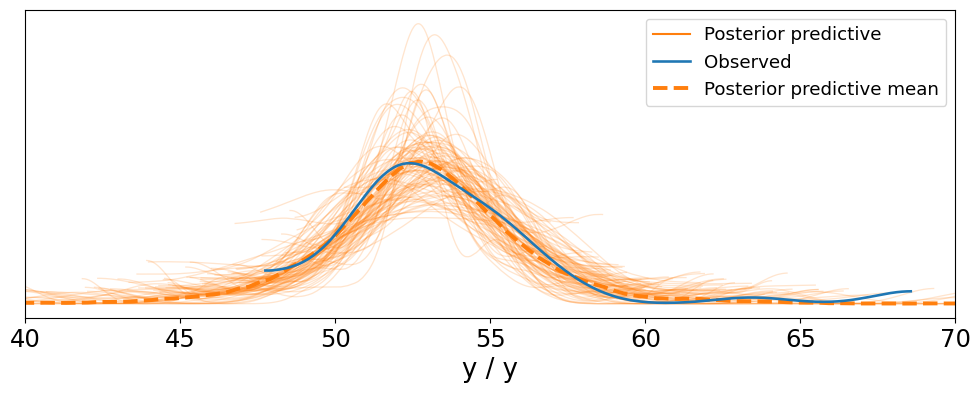

In [77]:
pm.sample_posterior_predictive(idata_t, model=model_t, extend_inferencedata=True, random_seed=123)
ax= az.plot_ppc(idata_t, figsize=(12, 4), num_pp_samples=100, mean=True, colors=["C1", "C0", "C1"])
ax.set_xlim(40, 70)
plt.savefig("../fig/idata_t_ppc.png")

In [83]:
idata_g

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [93]:
posterior = idata_g.posterior
posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    μ        (chain, draw) float64 54.01 53.79 53.79 53.55 ... 53.08 54.15 53.23
    σ        (chain, draw) float64 3.481 3.391 3.391 3.453 ... 3.582 4.049 3.262
Attributes:
    created_at:                 2024-07-03T08:42:25.286658
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              26.930812120437622
    tuning_steps:               1000

In [94]:
posterior.sel(draw=0, chain=[0, 2])

<xarray.Dataset>
Dimensions:  (chain: 2)
Coordinates:
  * chain    (chain) int64 0 2
    draw     int64 0
Data variables:
    μ        (chain) float64 54.01 53.85
    σ        (chain) float64 3.481 2.924
Attributes:
    created_at:                 2024-07-03T08:42:25.286658
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              26.930812120437622
    tuning_steps:               1000

In [119]:
posterior.sel(draw=slice(10,100))['μ'].values.shape

(4, 91)

In [115]:
posterior.sel(draw=range(0, 100))['σ'].shape

(4, 100)

In [121]:
posterior.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    μ        float64 53.5
    σ        float64 3.525

In [31]:
posterior.mean("draw")

<xarray.Dataset>
Dimensions:  (chain: 4)
Coordinates:
  * chain    (chain) int64 0 1 2 3
Data variables:
    μ        (chain) float64 53.52 53.5 53.5 53.49
    σ        (chain) float64 3.527 3.504 3.527 3.542

In [125]:
stacked = az.extract(idata_g)
stacked['μ']

<xarray.DataArray 'μ' (sample: 4000)>
array([54.01464173, 53.79250745, 53.79250745, ..., 53.08444666,
       54.15015846, 53.22932863])
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

In [129]:
az.extract(idata_g, group='posterior_predictive')['Y'].values.shape

(48, 4000)

In [137]:
az.extract(idata_g, num_samples=100)['μ'].values.shape

(100,)

## Comparaing groups

In [5]:
tips = pd.read_csv("data/tips.csv")
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


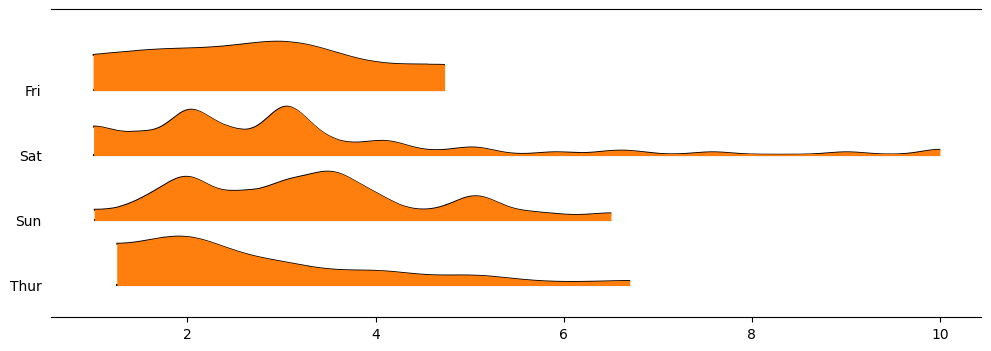

In [6]:
az.plot_forest(tips.pivot(columns="day", values="tip").to_dict("list"),
               kind="ridgeplot",
               hdi_prob=1,
               colors="C1",
               figsize=(12, 4))

plt.savefig("../fig/tips_ridgeplot.png")

In [157]:
from scipy.stats import gaussian_kde

In [243]:
# p = iqplot.histogram(
#     data=tips, q="tip", cats="day", density=True, rug=False,
#     fill_kwargs=dict(fill_alpha=0),
#     line_kwargs=dict(line_alpha=0,line_color="black"),
#     width=1000,
#     height=400
# )

# # Build the KDEs for each day

# for name, g in tips.groupby("day"):
#     # Evalues Gaussian KDE with default parameters (Scott's rule for bandwidth)
#     x_upper = np.linspace(g["tip"].min(), g["tip"].max(), 400)
#     x = x_upper

#     pdf_fun = gaussian_kde(g["tip"],bw_method=0.2)
#     y_vals = 1 * pdf_fun(x_upper)

#     x_closed = np.concatenate([[x[0]], x, [x[-1]]])  # Append first and last x values
#     y_closed = np.concatenate([[0], y_vals, [0]])  # Append 0 at start and end of y_vals

#     # Construct y-values for above and below category on y-axis
#     y_upper = [(name, y_val) for y_val in y_vals]
#     y_closed = [(name, y_val) for y_val in y_closed]

#     x = x_closed
#     y = y_upper

# #     # Add the KDE
#     p.line(x_upper, y_upper, color="black")
#     p.patch(x_closed, y_closed, fill_color="orange", alpha=0.8, level="underlay")


# p.yaxis.axis_line_color = None  # This makes the y-axis line invisible

# p.grid.visible = False

# p.outline_line_color = None

# bokeh.io.show(p)

In [7]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])

tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

idx

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0], dtype=int8)

In [8]:
coords = {"days": categories, "days_flat":categories[idx]}

coords

{'days': array(['Thur', 'Fri', 'Sat', 'Sun'], dtype='<U4'),
 'days_flat': array(['Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun',
        'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun',
        'Sun', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sun', 'Sun', 'Sun', 'Sun',
        'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun',
        'Sun', 'Sun', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Thur', 'Thur', 'Thur', 'Thur',
        'Thur', 'Thur', 'Thur', 'Thur', 'Thur', 'Thur', 'Thur', 'Thur',
        'Thur', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri',
        'Fri', 'Fri', 'Fri', 'Fri', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sun', 'Sun', 'Sun', 'Sun'

In [9]:
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal("μ", sigma=5, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample(random_seed=4591)
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg, random_seed=4591))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [y]


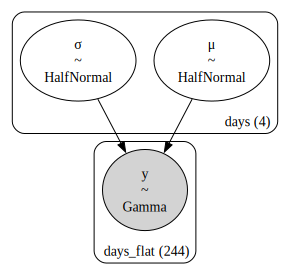

In [10]:
comparing_groups.to_graphviz()

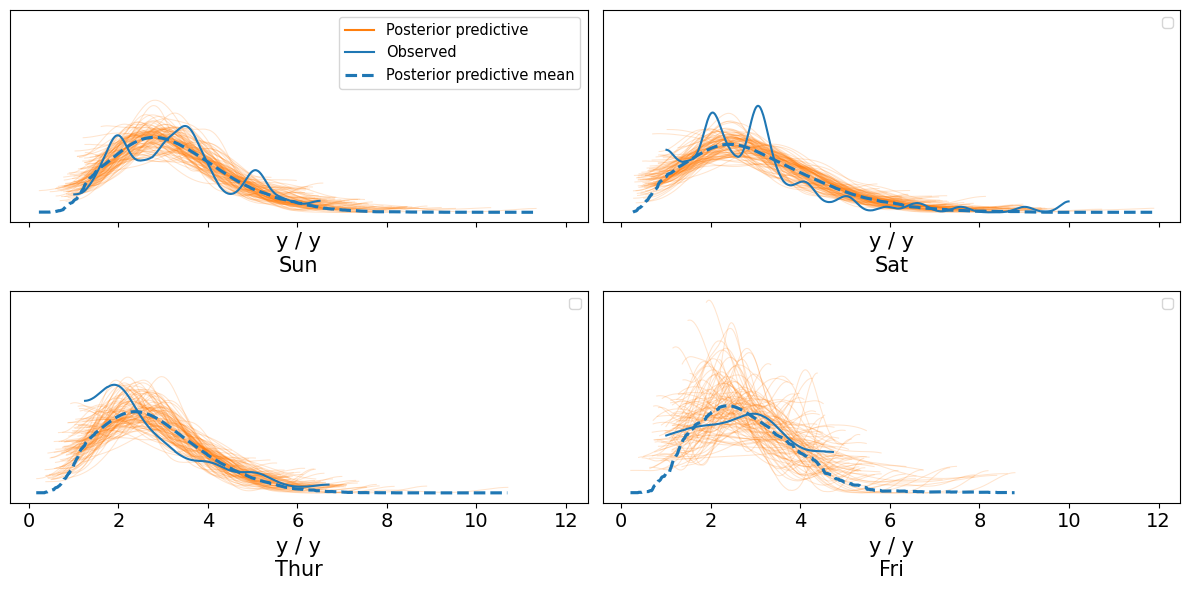

In [11]:
_, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
az.plot_ppc(idata_cg, num_pp_samples=100,
            colors=["C1", "C0", "C0"],
            coords={"days_flat":[categories]}, flatten=[], ax=axes)
plt.tight_layout()
plt.savefig("../fig/ppc_tips.png")

In [259]:
cg_posterior["μ"].sel(days='Thur')- cg_posterior['μ'].sel(days='Sat')

<xarray.DataArray 'μ' (sample: 4000)>
array([-0.25581114, -0.27271256, -0.29799792, ..., -0.25565083,
       -0.00304483, -0.13118471])
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

In [255]:
comparisons

[('Thur', 'Fri'),
 ('Thur', 'Sat'),
 ('Thur', 'Sun'),
 ('Fri', 'Sat'),
 ('Fri', 'Sun'),
 ('Sat', 'Sun')]

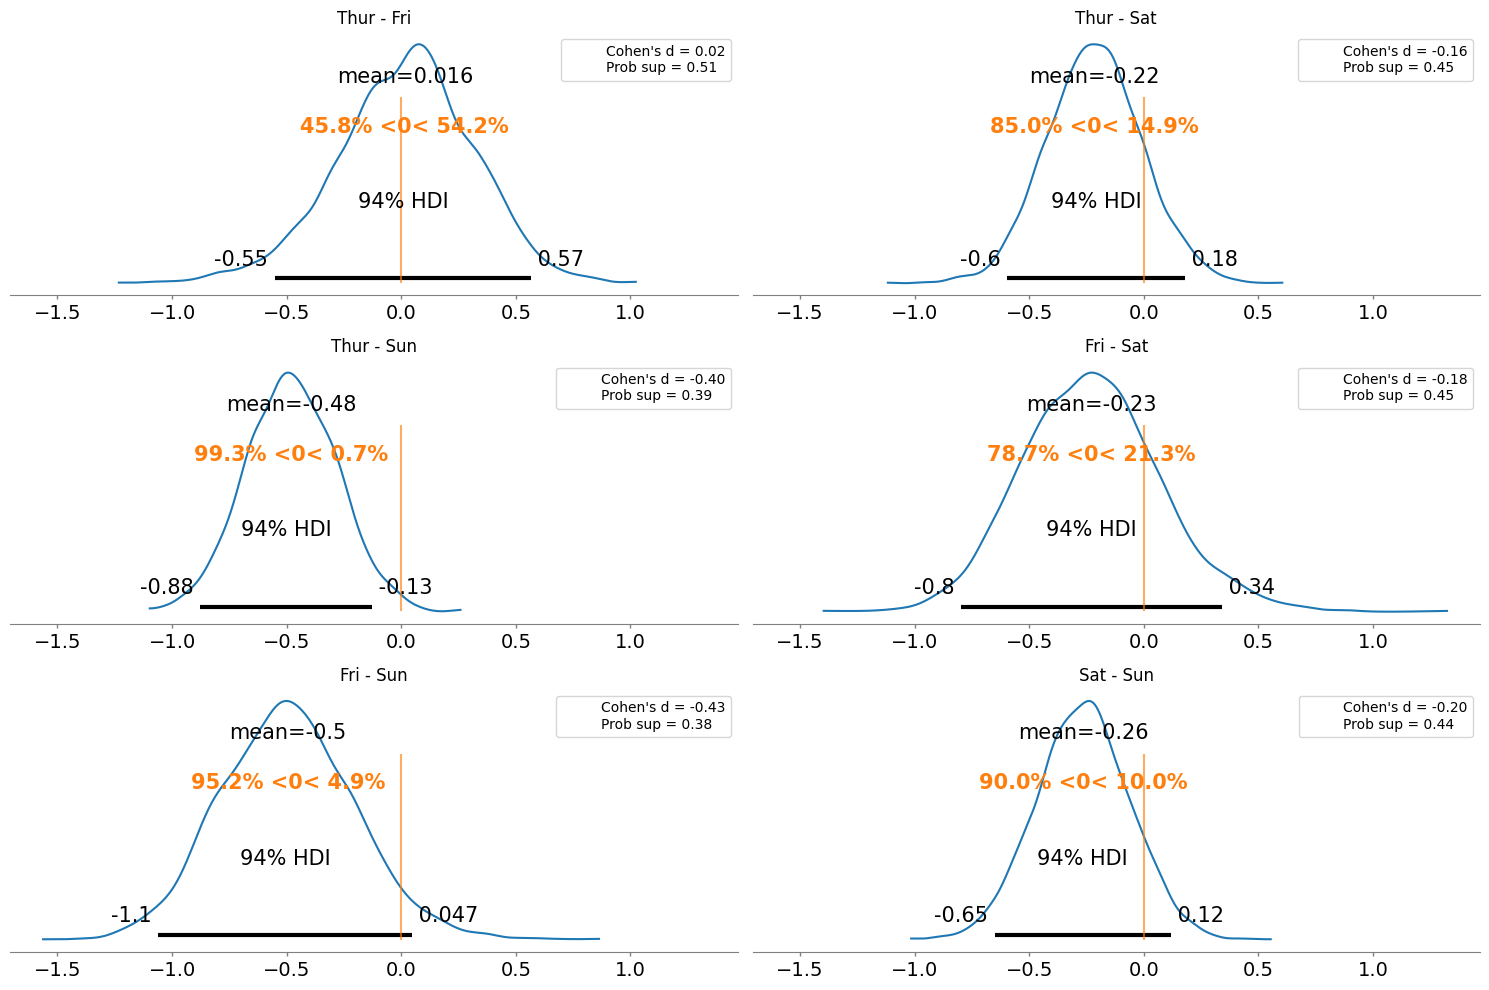

In [252]:
cg_posterior = az.extract(idata_cg)

dist = pz.Normal(0, 1)

comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]

_, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["μ"].sel(days=i) - cg_posterior['μ'].sel(days=j)
    
    d_cohen = (means_diff /
               np.sqrt((cg_posterior["σ"].sel(days=i)**2 + 
                        cg_posterior["σ"].sel(days=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend(loc=1)

    plt.tight_layout()
plt.savefig("../fig/tips_posterior.png")